In [1]:
extensions_loaded = False
if not extensions_loaded:
    %load_ext autoreload
    %load_ext tensorboard
    extensions_loaded = True

%autoreload 2
%matplotlib inline

In [2]:
import sys

import so_ml_tools as soml

import tensorflow as tf
import pandas as pd

import opendatasets as od

import tensorflow_hub as hub

from keras import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, GlobalAveragePooling1D, Flatten, Activation, TextVectorization, Embedding, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D
from keras.losses import binary_crossentropy

2023-09-11 21:42:15.399414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# NLP Fundamentals in TensorFlow

# Get a text dataset

The dataset we are going to be using is Kaggle's introduction to NLP dataset. These are text samples of Tweets labeled as disaster or not.

https://www.kaggle.com/competitions/nlp-getting-started

In [3]:
# Download the dogs and cats dataset
soml.util.io.download_file(source="https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip", filepath="./data/nlp_getting_started.zip")
soml.util.io.extract_zip(filepath="./data/nlp_getting_started.zip", folder="./data")

Download of https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip skipped, file ./data/nlp_getting_started.zip exists.
Download of https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip completed.


## Visualizing a text dataset

In [4]:
# Load test and training data.
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
soml.pd.dataframe.describe(train_df)

Total number of rows: 7613


,Column,DType,NotNull,Null,Unique,Mean,Std,Z-Min,Z-Max,Min,25%,50%,75%,Max
0,id,int64,7613,0,7613,5441.93,3137.12,-3969.41,14853.28,1.0,2734.0,5408.0,8146.0,10873.0
1,keyword,object,7552,61,221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,location,object,5080,2533,3341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,text,object,7613,0,7503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,target,int64,7613,0,2,0.43,0.50,-1.06,1.91,0.0,0.0,0.0,1.0,1.0


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Check if dataset is balanced

Read more about inbalanced classification on:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [8]:
# How many examples of each class are there, a balanced set would be 50/50, in this case it is 58/42 which is balanced enough.
train_df_shuffled.target.value_counts()
# train_df_shuffled.groupby(by='target').count()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# How many total samples, this is a 70/30
len(train_df_shuffled), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training samples
import random
random_index = random.randint(0, len(train_df) - 5) # Create random indexes not higher then the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row;
    print(f"Target: {target}", "(real dissaster)" if target > 0 else "(not real disaster)")
    print(f"Text: \n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text: 
Greg Garza not in the 18 for Atlas tonight vs Leones Negros in Copa MX play. He left the previous game w/ an injury. #USMNT

---

Target: 1 (real dissaster)
Text: 
...//..// whao.. 12000 Nigerian refugees repatriated from Cameroon http://t.co/po19h8YCND

---

Target: 1 (real dissaster)
Text: 
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/BB7TTdVJWE

---

Target: 0 (not real disaster)
Text: 
@Kiwi_Karyn Check out what's in my parking lot!! He said that until last year it was an ambulance in St Johns. http://t.co/hPvOdUD7iP

---

Target: 1 (real dissaster)
Text: 
@DarrellIssa Does that 'great Iran deal' cover bioterrorism? You got cut off terrible of them. Keep up the good work.

---



# Split data into training and validation sets.

In [11]:
train_sentences, val_sentences, train_labels, val_labels = soml.data.split.split_train_test_data(train_df_shuffled['text'].to_numpy(),
                                                                                     train_df_shuffled['target'].to_numpy(),
                                                                                     test_size=.1,
                                                                                     train_size=.9,
                                                                                     random_state=42)

In [12]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check first examples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Convert text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are few ways to this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create matrix of feature vectors for each token (the size of the feature vector can be defined and this embedding can be learned).

### Text vectorization (tokenization)

In [14]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

The processing of each example contains the following steps:

* Standardize each example (usually lowercasing + punctuation stripping)
* Split each example into substrings (usually words)
* Recombine substrings into tokens (usually ngrams)
* Index tokens (associate a unique int value with each token)
* Transform each example using this index, either into a vector of ints or a dense float vector.

In [15]:
# Use the default TextVectorization parameters

text_vectorizer = TextVectorization(
    max_tokens=None, # How many words in the vocabulary, it will automatically add a <OOV> token, OOV stands for Out Of Vocabulary, in get_vocabulary this results in [UNK]
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None, # Create groups of n-words
    output_mode="int", # How to map tokens to numbers
    output_sequence_length=None, # Fill with zeros to maintain consistent shape size
    pad_to_max_tokens=False, # Not applicable for output_mode = int, only for multi_hot, count and tf_idf
)

In [16]:
max_vocab_length = 10000 # Max number of words to have in our vocabulary
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # Max length our sequences will be (e.g. how many words of a tweet does a model see)

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int", # How to map tokens to numbers
    output_sequence_length=max_length, # Fill with zeros to maintain consistent shape size
)

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [18]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [19]:
# Choose a random sentence from the training dataset and tokenize it.
random_sentence = random.choice(train_sentences)
print(f"Original:\n{random_sentence}\n\nVectorized: {text_vectorizer([random_sentence])}")

Original:
Hurricane 30STM quem lembra

Vectorized: [[ 346    1 9422    1    0    0    0    0    0    0    0    0    0    0
     0]]


In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # Get all of the unique words in the vocabulary
f"10 Most common words {words_in_vocab[:10]}", f"10 Least common words: {words_in_vocab[-5:]}", f"Number of words in vocabulary: {len(words_in_vocab)}"

("10 Most common words ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']",
 "10 Least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']",
 'Number of words in vocabulary: 10000')

### Creating an Embedding using an Embedding Layer

To make our embedding we are going to use TensorFlows embedding layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:

* 'input_dim' = the size of our vocabulary
* 'output_dim' = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector of 100 long.
* 'input_length' = length of the sequences (also defined in the TextVectorization = 15)

In [21]:
embedding = Embedding(input_dim=max_vocab_length, # Set the input shape
                      output_dim=128, # Use a number that is divisble by 8
                      input_length=max_length # How long is each input sequence
                      )
embedding

In [22]:
# Get a random sentence from the the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: {random_sentence} \
      \n\rEmbedded version:")

# Embedd the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed


Original text: The Twitter update pretty much wrecked the app       
Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04517359, -0.01876922,  0.02538726, ...,  0.03637606,
         -0.03425814, -0.03931876],
        [ 0.0077947 ,  0.03090216, -0.00520393, ...,  0.02536942,
          0.02849669, -0.01644356],
        [-0.02179579,  0.00065679, -0.04614344, ...,  0.02368208,
          0.0247894 ,  0.00021025],
        ...,
        [ 0.03640367,  0.04004928,  0.0486244 , ..., -0.00091277,
         -0.00302501, -0.00956959],
        [ 0.03640367,  0.04004928,  0.0486244 , ..., -0.00091277,
         -0.00302501, -0.00956959],
        [ 0.03640367,  0.04004928,  0.0486244 , ..., -0.00091277,
         -0.00302501, -0.00956959]]], dtype=float32)>

In [23]:
# Check out a single tokens embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04517359, -0.01876922,  0.02538726,  0.00982172, -0.04562506,
         0.04693646, -0.01709185, -0.03930194,  0.04065529, -0.03664633,
         0.04748197, -0.00102154, -0.02494504, -0.00742596, -0.01656102,
        -0.00332718, -0.04268656,  0.02743901,  0.00395975, -0.01147819,
         0.01802759,  0.03457478,  0.00172976, -0.03889211,  0.04645802,
        -0.0234983 ,  0.035787  ,  0.02018196,  0.00783304, -0.02624028,
         0.0290301 , -0.03660272,  0.01899412,  0.01336536,  0.02810339,
         0.02672536, -0.02050385,  0.03914097,  0.04807315, -0.04673331,
        -0.03279858, -0.02468573, -0.04457077,  0.00165309,  0.0368934 ,
        -0.02636815, -0.04682325, -0.00334863, -0.03765128, -0.01329658,
        -0.04716344,  0.00451902, -0.00198636,  0.01832346, -0.04674784,
        -0.01779125, -0.04512415, -0.00260083,  0.02487929,  0.03065231,
         0.01907912, -0.02296436,  0.00179957,  0.04918945,  0.02990273,
  

## Modelling a text dataset (running a series of experiments)

Source:

* Model 0: Naive Bayes (baseline) Source: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed Forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D convolutional Neural Network
* Model 6: TensorFlow Hub pretrained feature extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with TensorFlow.

* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline

As with all machine learning experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

So to create our baseline will use SKLearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

Note: It's common practice to use non-DL (deep learning) algorithms as a baseline because of their speed and then later use DL to see if you can improve upon them.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words to numbers using TF-IDF
    ("clf", MultinomialNB()) # Model the text  (clf = classifier)
])

# Fit the pipeline to the training data.
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of 79.27%


Results are not bad, the training data consists of 4342 vs 3271 for non-disaster and disaster which is about 42% disaster samples and 58% non-disaster samples. If the model was guessing the result would be around 55%. So the baseline is doing a fair bit better then guessing.

In [26]:
# Make predictions
baseline_probs = model_0.predict(val_sentences)
baseline_probs[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our models predictions every time, however, this will be cumbersome and could easily be fixed with a function

Let's create one to compare our model's predictions with the truth labels using the folowing metrics:

* Accuracy
* Precission (high precision leads to less false positives)
* Recall (High recall leads to less false negatives)
* F1-Score (combination of precission / recall)

For a deep overview of many different evaluation methods, see the SKLearn documentation:

https://scikit-learn.org/stable/modules/model_evaluation.html

In [27]:
baseline_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_prob=baseline_probs)
baseline_results

,accuracy,f1-score,precision,recall
0,79.265092,0.786219,0.811139,0.792651


The model has a higher precision wich would lead to less false-positives.

# Model 1: Feed forward neural network (Dense model)

In [28]:
# Build model with the functional API
inputs = Input(shape=(1,), dtype=tf.string) # Inputs are 1-dimensional
x = text_vectorizer(inputs) # Turn the input text to numbers
x = embedding(x) # Create an embedding of the numberized inputs
x = GlobalAveragePooling1D()(x) # Condense the feature vector for each token to one vector
outputs = Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function

model_1 = Model(inputs, outputs, name="model_1_dense")

In [29]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [30]:
# Compile the model
model_1.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

In [31]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[soml.tf.fit.callback.tensorboard_callback(experiment_name="model_1_dense", dir_name="./model_logs")]
                              )

Saving TensorBoard log files to: ./model_logs/model_1_dense/20230911-214217
Epoch 1/5
215/215 [==============================] - 7s 27ms/step - loss: 0.6101 - accuracy: 0.6900 - val_loss: 0.5370 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4414 - accuracy: 0.8165 - val_loss: 0.4714 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3474 - accuracy: 0.8610 - val_loss: 0.4539 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 0s 2ms/step - loss: 0.2850 - accuracy: 0.8914 - val_loss: 0.4666 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2377 - accuracy: 0.9111 - val_loss: 0.4809 - val_accuracy: 0.7795


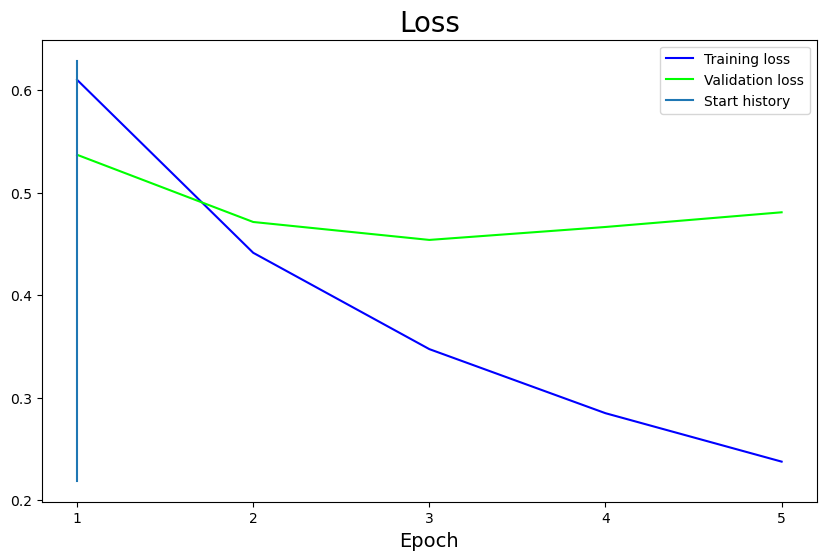

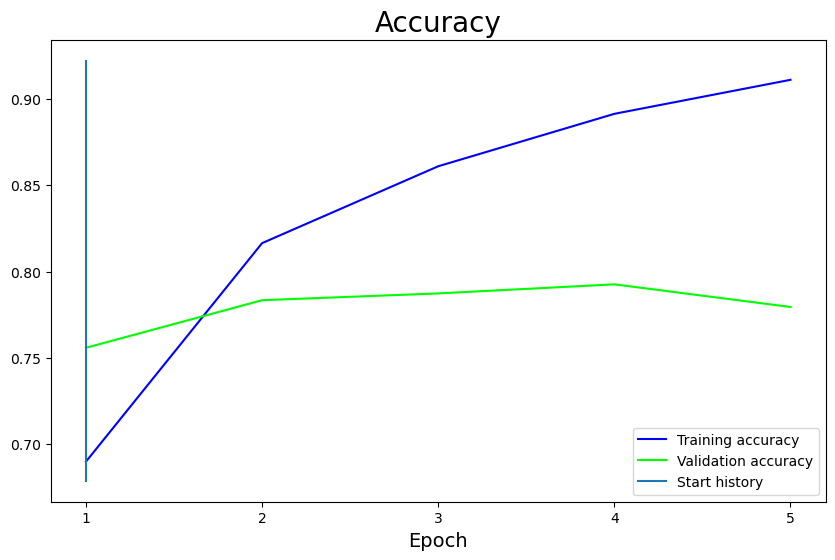

In [32]:
soml.tf.model.plot.plot_history(history=model_1_history)

In [33]:
# Evaluate the model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 806us/step - loss: 0.4809 - accuracy: 0.7795


[0.4808875024318695, 0.7795275449752808]

In [34]:
# Make some predictions
model_1_pred_propbs = model_1.predict(x=val_sentences)
model_1_pred_propbs[:10]

24/24 [==============================] - 0s 577us/step


array([[0.43815994],
       [0.78027385],
       [0.9967526 ],
       [0.17860019],
       [0.10525148],
       [0.9509011 ],
       [0.91182166],
       [0.993101  ],
       [0.97095245],
       [0.38081935]], dtype=float32)

In [35]:
model_1_pred_propbs.shape

(762, 1)

In [36]:
# Calculate our model one results
model_1_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_prob=model_1_pred_propbs)
model_1_results

,accuracy,f1-score,precision,recall
0,77.952756,0.777998,0.780435,0.779528


In [37]:
baseline_results

,accuracy,f1-score,precision,recall
0,79.265092,0.786219,0.811139,0.792651


In [38]:
# Comapre the results from both models (order does not have to be the same)
soml.evaluate.analyze.quality_metrics_diff(metrics_1=baseline_results, metrics_2=model_1_results)

,metrics,accuracy,f1-score,precision,recall
0,metrics_1,79.265092,0.786219,0.811139,0.792651
1,metrics_2,77.952756,0.777998,0.780435,0.779528
2,diff,1.312336,0.00822,0.030704,0.013123


Visualizing learned embeddings

In [39]:
# Get the vocabulary from the text verctorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [40]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [41]:
# Get the weight matrix of the embedding layer
# (these are the numerical representations of each token in our training data)
embed_weights = model_1.get_layer(name="embedding").get_weights()[0]

Now we've got the embeddings matrix our model has learned to represent our tokens, let's see how we can visualize it. To do so, TensorFlow has a handy tool called Projector.

https://projector.tensorflow.org

And TensorFlow also has an incredible guide on word embeddings themselfs.

In [42]:
# So for each token (total of 10.000 tokens in our vocabulary) we have a 128 length vector
embed_weights.shape

(10000, 128)

In [43]:
model_1

In [44]:
soml.nlp.embedding.export.embeddings(folder='./embedding/', text_vectorizer=text_vectorizer, model=model_1, 
                                     embedding_layer_name='embedding')

In [45]:
# TODO: Implement as function?

# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Recurrent neural networks

RNN's are useful for sequence data

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

If you want an overview of the internals of RNN, see the following:

- MIT: Sequence modelling lecture: https://youtu.be/ySEx_Bqxvvo
- LSTM Chris Olah: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

# Model 2: LSTM

LSTM = Long Short Term Memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:


```
Input (TEXT) -> Tokenize -> Embedding -> Layers (RNN's/Dense) -> Output (label probability)
```

In [46]:
# Create an LSTM model
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = LSTM(units=64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to return_sequences=True
print(x.shape)
x = LSTM(units=64)(x)
print(x.shape)
x = Dense(units=64, activation="relu")(x)
outputs = Dense(units=1, activation="sigmoid")(x)

model_2 = Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 15, 64)
(None, 64)


The input arguments for the LSTM are (batch, timesteps, feature), so in our case this is (batch=None, timesteps=15, feature=64)

In [47]:
# Create an LSTM model
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = LSTM(units=64, return_sequences=True)(x) # When you're stacking RNN cells together, you need to return_sequences=True
# print(x.shape)
x = LSTM(units=64)(x)
# print(x.shape)
# x = Dense(units=64, activation="relu")(x)
outputs = Dense(units=1, activation="sigmoid")(x)

model_2 = Model(inputs, outputs, name="model_2_LSTM")

In [48]:
# Get a summary.
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [49]:
# Compile the model
model_2.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [50]:
model_2_history = model_2.fit(
    x=train_sentences,
    y=train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels),
    callbacks=soml.tf.fit.callback.tensorboard_callback("model_2_lstm", dir_name="./model_logs")
)

Saving TensorBoard log files to: ./model_logs/model_2_lstm/20230911-214228
Epoch 1/5
215/215 [==============================] - 6s 22ms/step - loss: 0.2256 - accuracy: 0.9190 - val_loss: 0.5772 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1545 - accuracy: 0.9409 - val_loss: 0.6476 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1287 - accuracy: 0.9507 - val_loss: 0.7447 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.1038 - accuracy: 0.9609 - val_loss: 0.8598 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0806 - accuracy: 0.9683 - val_loss: 1.0476 - val_accuracy: 0.7822


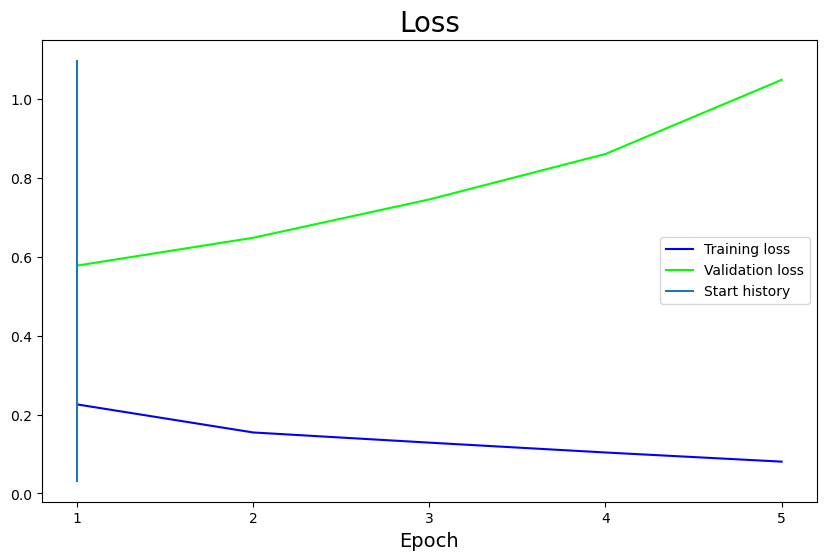

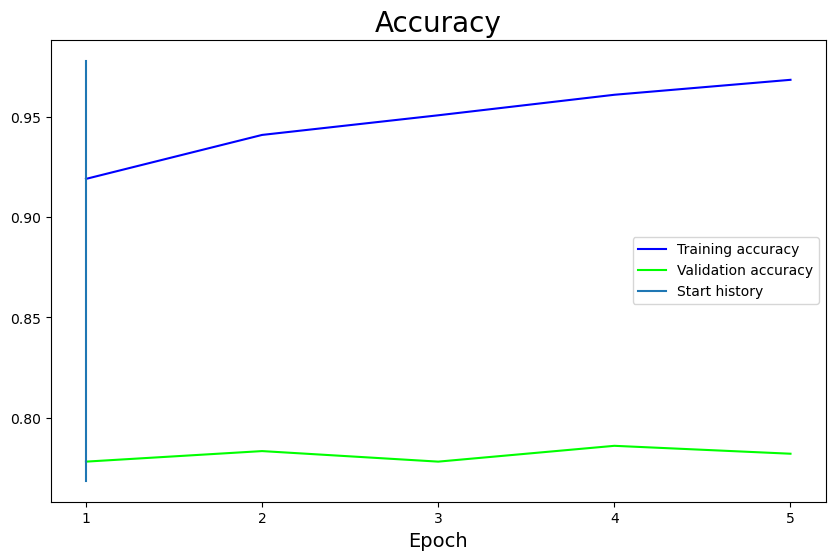

In [51]:
soml.tf.model.plot.plot_history(model_2_history)

In [52]:
model_2_pred_props = model_2.predict(val_sentences)
model_2_pred_props[:10]

24/24 [==============================] - 0s 902us/step


array([[1.7741658e-02],
       [6.9215393e-01],
       [9.9972647e-01],
       [4.0835910e-02],
       [3.7847355e-04],
       [9.9911684e-01],
       [9.8258466e-01],
       [9.9984145e-01],
       [9.9971575e-01],
       [6.1611366e-01]], dtype=float32)

In [54]:
# Check the results from model_2
model_2_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_prob=model_2_pred_props)
model_2_results

,accuracy,f1-score,precision,recall
0,78.215223,0.781054,0.782423,0.782152


In [55]:
baseline_results

,accuracy,f1-score,precision,recall
0,79.265092,0.786219,0.811139,0.792651


# Model 3: GRU

Another popular effective RNN component is the GRU - Gated Recurrent Unit.

The GRU cell (GRU Layer) has similar features to an LSTM cell but has less parameters.

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [56]:
# Build an RNN using the GRU cell
inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(units=64, return_sequences=False)(x)
outputs = Dense(1, activation="sigmoid")(x)
model_3 = Model(inputs, outputs, name="model_3_gru")

In [57]:
model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [58]:
model_3.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [59]:
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[soml.tf.fit.callback.tensorboard_callback("model_3_gru", dir_name="./model_logs")])

Saving TensorBoard log files to: ./model_logs/model_3_gru/20230911-214254
Epoch 1/5
215/215 [==============================] - 6s 22ms/step - loss: 0.1583 - accuracy: 0.9358 - val_loss: 0.7770 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0826 - accuracy: 0.9701 - val_loss: 0.8604 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0675 - accuracy: 0.9724 - val_loss: 1.1171 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0570 - accuracy: 0.9768 - val_loss: 1.2474 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0524 - accuracy: 0.9753 - val_loss: 1.3123 - val_accuracy: 0.7717


In [60]:
# Make some predictions
model_3_pred_props = model_3.predict(x=val_sentences)
model_3_pred_props[:10]

24/24 [==============================] - 0s 906us/step


array([[7.9383614e-04],
       [8.7466073e-01],
       [9.9989760e-01],
       [7.2440982e-02],
       [4.0693063e-05],
       [9.9974269e-01],
       [9.8795241e-01],
       [9.9994946e-01],
       [9.9991167e-01],
       [9.3233502e-01]], dtype=float32)

In [61]:
# Calculate model 3 results
model_3_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_prob=model_3_pred_props)
model_3_results

,accuracy,f1-score,precision,recall
0,77.165354,0.770183,0.772229,0.771654


In [62]:
model_2_results

,accuracy,f1-score,precision,recall
0,78.215223,0.781054,0.782423,0.782152


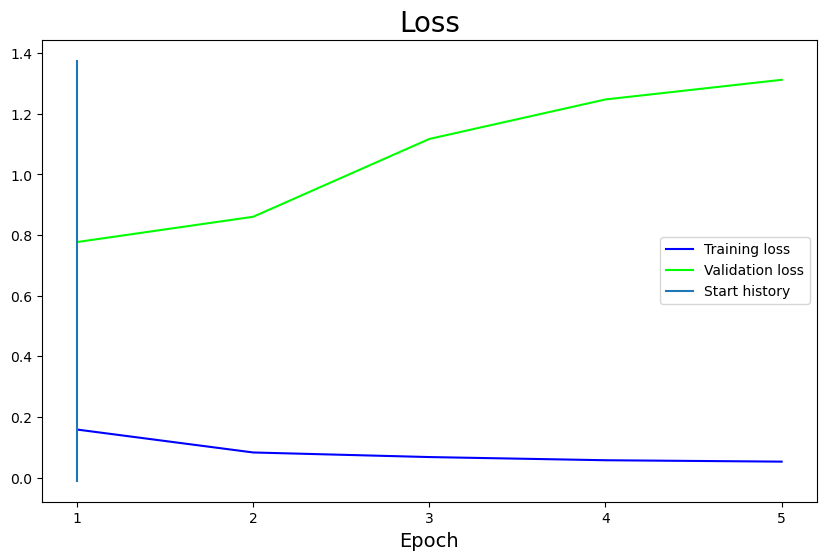

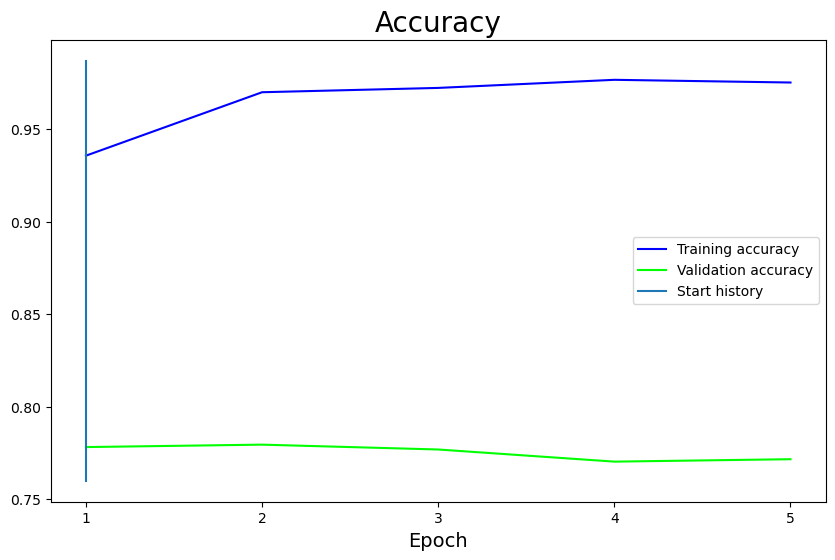

In [63]:
soml.tf.model.plot.plot_history(history=model_3_history)

# Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however, bidirectionals go from right to left as well as left to right.

In [64]:
# Build a bidirectional RNN in TensorFlow

inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(layer=LSTM(units=64, return_sequences=False))(x)
# x = Bidirectional(layer=GRU(units=64))(x)
outputs = Dense(1, activation="sigmoid")(x)

model_4 = Model(inputs, outputs, name="model_4_bidirectional")

In [65]:
# Get a summary

model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [66]:
# Compile the model
model_4.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [67]:
model_4_history = model_4.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[soml.tf.fit.callback.tensorboard_callback("model_3_bidirectional", dir_name="./model_logs")])

Saving TensorBoard log files to: ./model_logs/model_3_bidirectional/20230911-214304
Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.1061 - accuracy: 0.9707 - val_loss: 0.9238 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0512 - accuracy: 0.9777 - val_loss: 1.1265 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0455 - accuracy: 0.9794 - val_loss: 1.2293 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0454 - accuracy: 0.9793 - val_loss: 1.4145 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0411 - accuracy: 0.9806 - val_loss: 1.2885 - val_accuracy: 0.7703


In [68]:
# Make predictions abnd calculate results of our bidirectional model.
model_4_pred_props = model_4.predict(val_sentences)
model_4_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_prob=model_4_pred_props)
model_4_results

24/24 [==============================] - 1s 1ms/step


,accuracy,f1-score,precision,recall
0,77.034121,0.768323,0.771825,0.770341


# Model 5: Conv1D

We've used CNN's for images are typically 2D (HxW), however our text data is 1D.

Previously we have used Conv2D for our image data, but now we will use Conv1D.
The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layers (Conv1D + Pooling) -> Outputs (Dense layer)
```

For different explanations of parameter values:

CNN-Explainer: https://poloclub.github.io/cnn-explainer/
Same and Valid: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [69]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_text = embedding(text_vectorizer(['this is a test sentence'])) # Turn target sequence into an embedding
conv_1d = Conv1D(filters=64,
                 kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                 strides=1,
                 activation="relu",
                 padding="valid") # valid = output is smaller due to kernel_size / strides, change to same to pad values before / after the sequence.
conv_1d_output = conv_1d(embedding_text) # pass test embedding through conv_1d layer
max_pool = GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_text.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 64]), TensorShape([1, 64]))

In [70]:
# Create 1-dimensional convolutional layer to model sequences

inputs = Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(filters=64,
           kernel_size=5, # 5 words at a time.
           strides=1,
           activation="relu",
           padding="valid")(x)
# x = Flatten()(x)
x = GlobalMaxPooling1D()(x)
outputs = Dense(units=1, activation="sigmoid")(x)

model_5 = Model(inputs, outputs, name="model_4_conv1d")

In [71]:
model_5.summary()

Model: "model_4_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 1)              

In [72]:
model_5.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [73]:
model_5_history = model_5.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[soml.tf.fit.callback.tensorboard_callback(experiment_name="model_5_conv1d", dir_name="./model_logs")])

Saving TensorBoard log files to: ./model_logs/model_5_conv1d/20230911-214317
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.1285 - accuracy: 0.9543 - val_loss: 0.8846 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0756 - accuracy: 0.9704 - val_loss: 1.0022 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0610 - accuracy: 0.9759 - val_loss: 1.1384 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 1s 2ms/step - loss: 0.0541 - accuracy: 0.9780 - val_loss: 1.1811 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0507 - accuracy: 0.9809 - val_loss: 1.1960 - val_accuracy: 0.7625


In [74]:
model_5_pred_props = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_props))
model_5_results = soml.evaluate.analyze.quality_metrics(val_labels, model_5_preds)
model_5_results

24/24 [==============================] - 0s 635us/step


,accuracy,f1-score,precision,recall
0,76.246719,0.760995,0.762803,0.762467


# Model 6: TensorFlow Hub Pretrained Sentence Encode

Now we've build a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow's Hub's Universal Sentence Encoder

https://huggingface.co/docs/transformers/index
https://tfhub.dev/google/universal-sentence-encoder/4
https://arxiv.org/abs/1803.11175

In [75]:
embed = hub.load(handle="https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence, "When you call the universal sentence encoder on a sentence it turns it into numbers"])
print(embed_samples)

tf.Tensor(
[[-0.01157027  0.02485911  0.02878048 ... -0.00186124  0.02315824
  -0.01485022]
 [ 0.03596688 -0.08579469 -0.01152741 ... -0.03414335  0.02816023
  -0.00878943]], shape=(2, 512), dtype=float32)


In [76]:
# Create Keras Layer using the USE pretrained layer from TensorFlow Hub
sentence_encoder_layer = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[], # Since the input is defined as english text of variable length the layer in itself will make sure it fits
                                        dtype=tf.string,
                                        trainable=False, # we are doing feature extraction so we do not want to train this layer
                                        name='USE'
                                      )

In [77]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_6.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [78]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(x=train_sentences,
            y=train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[soml.tf.fit.callback.tensorboard_callback("model_6_use", dir_name='./model_logs')])

Saving TensorBoard log files to: ./model_logs/model_6_use/20230911-214354
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.5019 - accuracy: 0.7881 - val_loss: 0.4543 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4153 - accuracy: 0.8170 - val_loss: 0.4508 - val_accuracy: 0.7992
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4028 - accuracy: 0.8210 - val_loss: 0.4362 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3950 - accuracy: 0.8257 - val_loss: 0.4335 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3879 - accuracy: 0.8298 - val_loss: 0.4337 - val_accuracy: 0.8189


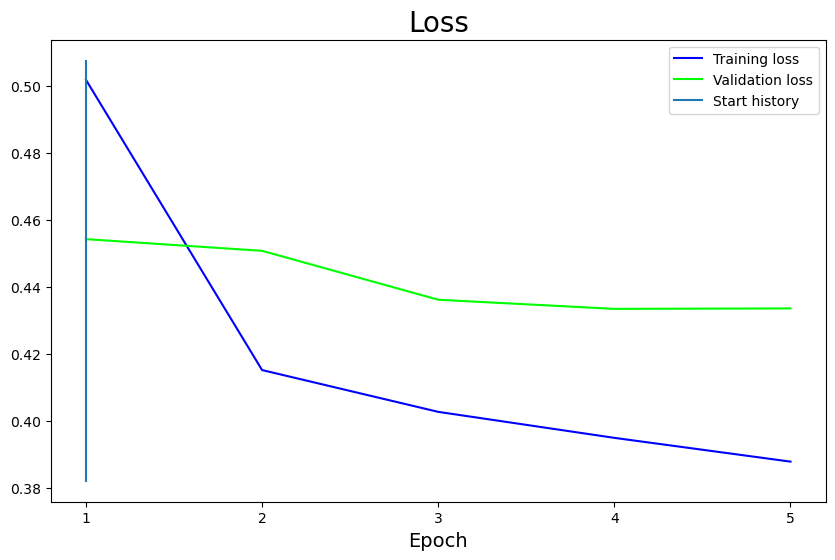

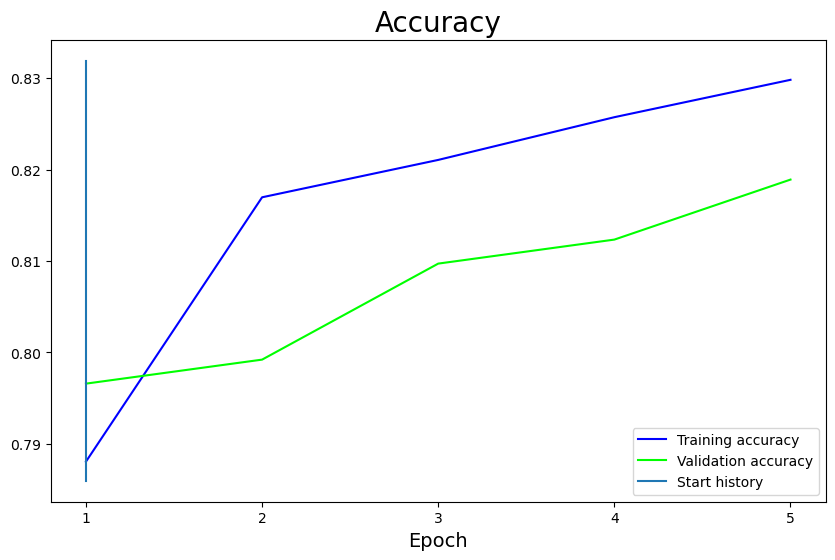

In [79]:
soml.tf.model.plot.plot_history(model_6_history)

In [80]:
# Make predictions with the USE TF Hub Model
model_6_pred_props = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_props))
model_6_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_pred=model_6_preds)
model_6_results

24/24 [==============================] - 0s 3ms/step


,accuracy,f1-score,precision,recall
0,81.889764,0.817454,0.82113,0.818898


In [81]:
baseline_results

,accuracy,f1-score,precision,recall
0,79.265092,0.786219,0.811139,0.792651


# Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer Learning really helps when you don't have a large dataset, to see how our model performs on a smaller dataset, let's replicate model_6 except we'll train it on 10% of the data.

In [82]:
## Model 7: TF Hub Pretrained USE but with 10% of training data
# Note: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% of the data). DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAING SET (OR VICE VERSA)
# train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=.1, random_state=42)
# train_sentences_10_percent = train_10_percent['text']
# train_labels_10_percent = train_10_percent['target']
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [83]:
train_10_percent_split = int(.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_sentences_10_percent), len(train_labels_10_percent), train_sentences_10_percent[:10], train_labels_10_percent[:10]

(685,
 685,
 array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object)

In [84]:
# Check the number of targets in our 10 percent dataset
pd.Series(train_labels_10_percent).value_counts()

0    406
1    279
Name: count, dtype: int64

In [85]:
# Check the number of each label in the updated training data subset.
train_df_shuffled['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

To recreate a model the same as a previous model you've crfeated you can use the 'tf.keras.models.clone_model()' method.

In [86]:
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model_7.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=['accuracy'])

In [87]:
# Fit the model using 10% of the training data.
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[soml.tf.fit.callback.tensorboard_callback(experiment_name='model_7_use_10_percent', dir_name='./model_logs')])

Saving TensorBoard log files to: ./model_logs/model_7_use_10_percent/20230911-214402
Epoch 1/5
22/22 [==============================] - 1s 18ms/step - loss: 0.6672 - accuracy: 0.6832 - val_loss: 0.6466 - val_accuracy: 0.7087
Epoch 2/5
22/22 [==============================] - 0s 8ms/step - loss: 0.5948 - accuracy: 0.7927 - val_loss: 0.5872 - val_accuracy: 0.7703
Epoch 3/5
22/22 [==============================] - 0s 8ms/step - loss: 0.5195 - accuracy: 0.8219 - val_loss: 0.5336 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 0s 8ms/step - loss: 0.4619 - accuracy: 0.8219 - val_loss: 0.5025 - val_accuracy: 0.7795
Epoch 5/5
22/22 [==============================] - 0s 9ms/step - loss: 0.4209 - accuracy: 0.8350 - val_loss: 0.4909 - val_accuracy: 0.7769


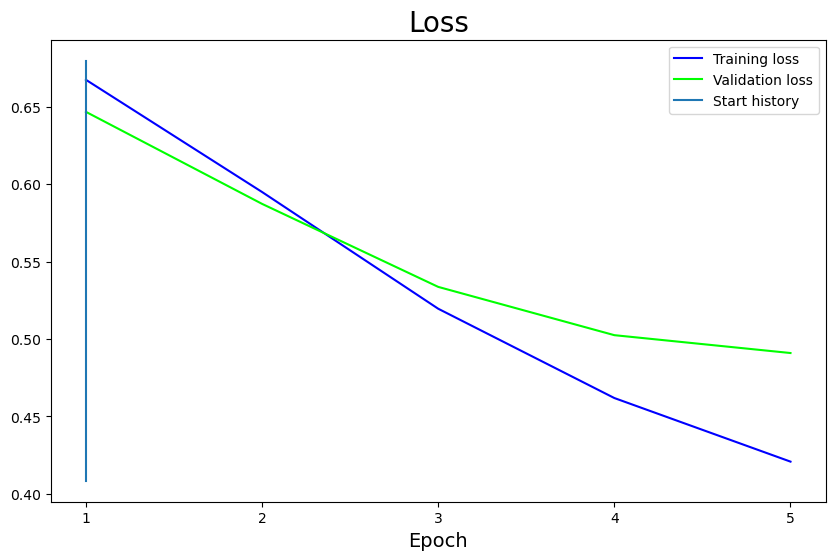

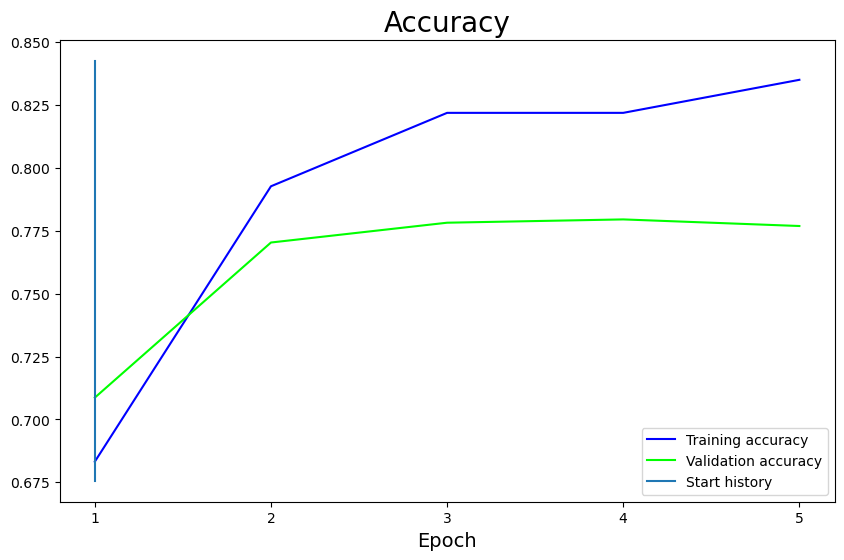

In [88]:
soml.tf.model.plot.plot_history(history=model_7_history)

In [89]:
# Make some predictions
model_7_pred_props = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_props))
model_7_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_pred=model_7_preds)
model_7_results

24/24 [==============================] - 0s 3ms/step


,accuracy,f1-score,precision,recall
0,77.690289,0.775678,0.777243,0.776903


In [90]:
baseline_results

,accuracy,f1-score,precision,recall
0,79.265092,0.786219,0.811139,0.792651


Note: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% of the data). DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAING SET (OR VICE VERSA)

In [92]:
soml.tf.tensorboard.start_tensorboard(target_dir='./model_logs')

http://localhost:6006


2023-09-11 21:44:28.831502: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)


In [94]:
soml.tf.tensorboard.stop_tensorboard()

TensorBoard caught SIGTERM; exiting...


# Comparing the performance of each of our models

In [115]:
# Combine model results into a dataframe
# TODO: Turn into function for mlp
all_model_results = pd.concat(
    {
        "0_baseline" : baseline_results,
        "1_simple_dense": model_1_results,
        "2_lstm": model_2_results,
        "3_gru": model_3_results,
        "4_bidirectional": model_4_results,
        "5_conv1d": model_5_results,
        "6_tf_hub_100": model_6_results,
        "7_tf_hub_10": model_7_results
    }
)

all_model_results.reset_index(inplace=True)
soml.pd.dataframe.drop_columns(dataframe=all_model_results, column_names=['level_1'])
all_model_results.rename(columns={"level_0": "name"}, inplace=True)
all_model_results.sort_values(by=["accuracy"], inplace=True)
all_model_results

,name,accuracy,f1-score,precision,recall
5,5_conv1d,76.246719,0.760995,0.762803,0.762467
4,4_bidirectional,77.034121,0.768323,0.771825,0.770341
3,3_gru,77.165354,0.770183,0.772229,0.771654
7,7_tf_hub_10,77.690289,0.775678,0.777243,0.776903
1,1_simple_dense,77.952756,0.777998,0.780435,0.779528
2,2_lstm,78.215223,0.781054,0.782423,0.782152
0,0_baseline,79.265092,0.786219,0.811139,0.792651
6,6_tf_hub_100,81.889764,0.817454,0.821130,0.818898


In [ ]:
# Reduce accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy']/100

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values(by='f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

In [ ]:
soml.tf.tensorboard.start_tensorboard(dir_name='./model_logs')

In [ ]:
soml.tf.tensorboard.stop_tensorboard()

# Saving and loading a trained model

There are two main formats in tensorflow:

1. The HDF5 format
2. The 'SavedModel' format (this is the default when using TensorFlow)

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save(filepath="./models/model_6.h5")

In [ ]:
# Load model with custom hub-layer, this is required with the HDF5 format.
loaded_model_6 = soml.tf.model.io.load_model(filepath="./models/model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# Evaluate the model
loaded_model_6.evaluate(val_sentences, val_labels)

In [ ]:
model_6_results

In [ ]:
# And now let's save to the Save Model format.
soml.tf.model.io.save_model(model_6, filepath="./models/model_6.tf", save_format="tf")

In [ ]:
# Load model with custom hub-layer, this is required with the HDF5 format.
loaded_model_6 = soml.tf.model.io.load_model(filepath="./models/model_6.tf",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# Evaluate the model
loaded_model_6.evaluate(val_sentences, val_labels)

# Find the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong.
* And of these wrong examples which ones is it getting *most* wrong, those will prediction probability closest to the oposite class).

For example if a sample should have a label of 0, but our model prediction probability of 0.999 (really close to 1) and vice versa.

This is called Model Driven Data Exploration, using the validation data and prediction probabilities and labels to find the most wrong awnsers and see if the data is wrongly labeled or if the data is just not suitable for the required end-result or if we might have errors in our model.


In [ ]:
# Download pretrained model from Google Storage
soml.util.io.download_file(source='https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip', filepath='./data/08_model_6_USE_feature_extractor.zip')
soml.util.io.extract_zip(file='./data/08_model_6_USE_feature_extractor.zip', folder='./data')

In [ ]:
model_6_pretrained = mll.load_model(filepath='./data/08_model_6_USE_feature_extractor')

In [ ]:
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))

In [ ]:
# TODO: Function
val_df = pd.DataFrame(
    {
        "text": val_sentences,
        "y_true": val_labels,
        "y_pred": model_6_pretrained_preds,
        "y_prob": tf.squeeze(model_6_pretrained_pred_probs)
    })
val_df.head()

In [ ]:
most_wrong = val_df[val_df['y_true'] != val_df['y_pred']].sort_values(by='y_prob', ascending=False)
most_wrong[:10] # False Positives

In [ ]:
most_wrong[-10:] # False Negatives

In [ ]:
# Check the false positives (model predicted 1 but should have been 0)
for row in most_wrong[:10].itertuples():
    _, text, y_true, y_pred, y_prob = row
    print(f"Target: {y_true}, Pred: {y_pred}, Prob: {y_prob}")
    print(f"Text: \n{text}\n")
    print("---")

In [ ]:
# Check the false positives (model predicted 1 but should have been 0)
for row in most_wrong[-10:].itertuples():
    _, text, y_true, y_pred, y_prob = row
    print(f"Target: {y_true}, Pred: {y_pred}, Prob: {y_prob}")
    print(f"Text: \n{text}\n")
    print("---")

# Making predictions on the test dataset

In [ ]:
model_6_pretrained_pred_probs_test = model_6_pretrained.predict(test_df['text'].to_numpy())
model_6_pretrained_preds_test = tf.squeeze(tf.round(model_6_pretrained_pred_probs_test))

In [ ]:
test_df['y_pred'] = model_6_pretrained_preds_test
test_df['y_prod'] = tf.squeeze(model_6_pretrained_pred_probs_test)
test_df.sort_values(by='y_prod', ascending=False)

In [ ]:
test_df

# The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
    """
    Times how long  a model takes to make a prediction.

    :param model:
    :param samples:
    :return:
    """
    start_time = time.perf_counter()
    model.predict(samples)
    end_time = time.perf_counter()
    total_time = end_time - start_time # Calculate how long predictions took to make
    time_per_pred  = total_time / len(samples)
    return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encode time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

In [ ]:
# Calculate baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model=model_0,
                                                            samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

In [ ]:
model_6_pretrained_results = soml.evaluate.analyze.quality_metrics(y_true=val_labels, y_pred=model_6_pretrained_preds)
model_6_pretrained_results

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(x=baseline_time_per_pred, y=baseline_results["f1"], label="baseline")
plt.scatter(x=model_6_time_per_pred, y=model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1 Score vs Time per pred")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score")